In [1]:
import warnings
import time
import pandas as pd
from tqdm import tqdm

from helpers import classification as pf
from helpers import stats as bf
from helpers.file import save_file
from helpers.simulation_logger import SimulationLogger
from helpers.model_config import custom_models_config

warnings.filterwarnings("ignore")

start_time = time.time()

Setup Complete


In [ ]:
league = "japan-j1-league"
start_season = 2012
last_season = 2025
save_pipeline_bool = True
random_state = 0

min_games_played = 10
min_games_played_at = 5

betting_starts_after_n_games = 0

filtered_cols = [
    'home_points_pct', 
    'home_win_pct', 'home_draw_pct', 'home_loss_pct',
    'home_points_pct_last_games',
    # 'home_win_pct_last_games', 'home_draw_pct_last_games', 'home_loss_pct_last_games',
    'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct',
    'home_team_xg', 'home_opp_xg',
    'home_home_team_xg', 'home_home_opp_xg',
    'home_team_score', 'home_opp_score',
    'home_home_team_score', 'home_home_opp_score',
    'away_points_pct', 
    'away_win_pct', 'away_draw_pct', 'away_loss_pct',
    'away_points_pct_last_games',
    # 'away_win_pct_last_games', 'away_draw_pct_last_games', 'away_loss_pct_last_games',
    'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct',
    'away_team_xg', 'away_opp_xg',
    'away_away_opp_xg', 'away_away_team_xg',
    'away_team_score', 'away_opp_score',
    'away_away_opp_score', 'away_away_team_score', 
    'home_elo', 'away_elo',
    'home_odds', 'away_odds', 'draw_odds',
    "home_ahc_odds",
    "ahc_line",
    "away_ahc_odds",
    "overs_odds",
    "totals_line",
    "unders_odds",
]

# Market configurations for different bet types
# Each market has a list of possible outcomes, a threshold for betting, and a list of models to use in the VotingClassifier
markets = {
    "result": [["H", "D", "A"], 2.2, ["naive_bayes", "logistic_regression"]],
    "ahc_result": [["H", "A", "P"], 2, ["mlp", "ada_boost"]],
    "totals_result": [["O", "U", "P"], 1.7, ["random_forest", "svm"]]
}

fast_simulation = True
preprocess = False
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

In [3]:
# Initialize logger
logger = SimulationLogger(league)

# Log all configuration parameters
logger.log_config(
    league=league,
    start_season=start_season,
    save_pipeline=save_pipeline_bool,
    random_state=random_state,
    min_games_played=min_games_played,
    min_games_played_at=min_games_played_at,
    betting_starts_after_n_games=betting_starts_after_n_games,
    filtered_cols=filtered_cols,
    markets=markets,
    fast_simulation=fast_simulation,
    preprocess=preprocess,
    bankroll=bankroll,
    strategy=strategy,
    default_value=default_value,
    default_bankroll_pct=default_bankroll_pct,
    plot_threshold=plot_threshold,
    custom_models_config=custom_models_config if 'custom_models_config' in globals() else None
)

📁 Simulation directory created: ../dist/simulations\japan-j1-league\2025-08-30_12-10-05


In [4]:
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 2849/2849 [00:00<00:00, 8482.39it/s]

Successfully generated teams ELOs.


,season,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,league,...,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds,result,ahc_result,totals_result,home_elo,away_elo
0,2017,2017-02-25,1,Cerezo Osaka,None,0,0,None,Júbilo Iwata,japan-j1-league,...,0.50,2.05,1.92,2.50,1.92,D,A,U,1500.00,1500.00
1,2017,2017-02-25,1,Kashima Antlers,None,0,1,None,FC Tokyo,japan-j1-league,...,0.25,1.98,1.88,2.25,1.98,A,A,U,1500.00,1500.00
2,2017,2017-02-25,1,Marinos,None,3,2,None,Urawa Reds,japan-j1-league,...,-0.50,2.02,1.98,2.50,1.88,H,H,O,1500.00,1500.00
3,2017,2017-02-25,1,Omiya Ardija,None,0,2,None,Kawa Frontale,japan-j1-league,...,-0.25,2.12,1.90,2.50,1.95,A,A,U,1500.00,1500.00
4,2017,2017-02-25,1,S-Pulse,None,0,1,None,Vissel Kobe,japan-j1-league,...,-0.50,2.20,1.90,2.50,1.95,A,A,U,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,2025,2025-08-10,25,Grampus,None,1,2,None,Kyoto Sanga,japan-j1-league,...,0.00,1.88,2.05,2.25,1.75,A,A,O,1511.06,1582.83
2845,2025,2025-08-10,25,Kashiwa Reysol,None,2,0,None,Shonan Bellmare,japan-j1-league,...,1.25,1.90,1.95,2.50,1.85,H,H,U,1557.52,1447.29
2846,2025,2025-08-10,25,Machida Zelvia,None,2,0,None,Vissel Kobe,japan-j1-league,...,0.00,2.05,2.05,2.25,1.75,H,H,U,1596.33,1680.95
2847,2025,2025-08-10,25,Sanfrecce,None,0,0,None,S-Pulse,japan-j1-league,...,0.50,2.03,2.00,2.25,1.80,D,A,U,1633.05,1474.48


In [5]:
data_model = []

for index, game in tqdm(matches.iterrows(), total=len(matches)):
    if pd.isnull(game["home_odds"]):
        continue

    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict:
        continue

    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not away_stats_dict:
        continue

    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "ahc_result",
        "totals_result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
        "home_ahc_odds",
        "ahc_line",
        "away_ahc_odds",
        "overs_odds",
        "totals_line",
        "unders_odds",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}

    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})

data_df = pd.DataFrame(data_model)

100%|██████████| 2849/2849 [00:49<00:00, 57.62it/s] 


In [6]:
display(data_df)

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_score,away_score,home_elo,away_elo,home_ahc_odds,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.200000,...,1,2,1538.73,1525.59,1.82,0.25,2.02,1.88,2.50,1.98
1,0.700000,0.700000,0.000000,0.300000,0.700000,0.7,0.0,0.3,0.400000,0.000000,...,1,2,1535.95,1503.58,1.78,0.50,2.10,1.88,2.50,1.98
2,0.133333,0.100000,0.100000,0.800000,0.133333,0.1,0.1,0.8,0.200000,0.000000,...,2,1,1423.85,1468.56,1.90,0.00,1.95,1.98,2.50,1.88
3,0.636364,0.636364,0.000000,0.363636,0.700000,0.7,0.0,0.3,0.333333,0.000000,...,0,3,1525.02,1531.85,1.82,0.25,2.02,1.70,2.25,2.20
4,0.151515,0.090909,0.181818,0.727273,0.133333,0.1,0.1,0.8,0.000000,0.000000,...,1,0,1415.34,1473.72,1.78,0.00,2.10,1.88,2.25,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,0.388889,0.291667,0.291667,0.416667,0.466667,0.3,0.5,0.2,0.454545,0.363636,...,1,2,1511.06,1582.83,1.93,0.00,1.88,2.05,2.25,1.75
1925,0.611111,0.500000,0.333333,0.166667,0.566667,0.5,0.2,0.3,0.454545,0.363636,...,2,0,1557.52,1447.29,1.90,1.25,1.90,1.95,2.50,1.85
1926,0.555556,0.500000,0.166667,0.333333,0.666667,0.6,0.2,0.2,0.363636,0.090909,...,2,0,1596.33,1680.95,1.75,0.00,2.05,2.05,2.25,1.75
1927,0.583333,0.541667,0.125000,0.333333,0.533333,0.5,0.1,0.4,0.545455,0.090909,...,0,0,1633.05,1474.48,1.78,0.50,2.03,2.00,2.25,1.80


In [7]:
# Prepare a list of function calls for each season
function_calls = []

for season in range(start_season + 1, last_season + 1):
    for result_col, market_values in markets.items():
        class_order, _, voting_models = market_values

        matches_filtered = pf.get_filtered_matches(
            data_df,
            filtered_cols,
            start_season,
            season
        )

        if season != last_season and not len(matches_filtered[matches_filtered["season"] < season]):
            continue

        # Store a tuple with season, result_col, and a lambda function
        function_calls.append((
            season,
            result_col,
            lambda season=season, result_col=result_col, class_order=class_order: pf.simulate_with_classification(
                data_df,
                start_season,
                season,
                filtered_cols,
                random_state=random_state,
                preprocess=preprocess,
                result_col=result_col,
                class_order=class_order,
                fast_simulation=fast_simulation,
                custom_models_config=custom_models_config,
                voting_models=voting_models,
            )
        ))

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
last_season_models = {}

# Initialize matches outside the loop
matches = data_df.copy()

for season, result_col, func in tqdm(function_calls):
    season_matches, trained_models = func()
    
    # Update the main matches dataframe with new values
    for col in season_matches.columns:
        # Only update rows that exist in matches
        matches.loc[season_matches.index, col] = season_matches[col]

    if season == last_season:
        last_season_models[result_col] = trained_models

Training and evaluating models throughout the seasons...


100%|██████████| 24/24 [02:18<00:00,  5.76s/it]


In [8]:
# Replace the model accuracy cell with:

models = pf.get_classification_models()

def show_all_accuracies():
    print("1x2 Model Accuracies:")
    pf.show_classification_accuracies(matches, models, result_col="result")
    
    print("\nAHC Model Accuracies:")
    pf.show_classification_accuracies(matches, models, result_col="ahc_result")
    
    print("\nTotals Models Accuracies:")
    pf.show_classification_accuracies(matches, models, result_col="totals_result")

# Capture and save the accuracy outputs
logger.capture_print(show_all_accuracies, "Model Accuracies Comparison")

# Also save to dedicated file
logger.save_model_accuracies(matches, models, markets)

1x2 Model Accuracies:
logistic_regression: Accuracy = 0.4660
knn: Accuracy = 0.4479
svm: Accuracy = 0.4386
ada_boost: Accuracy = 0.4386
naive_bayes: Accuracy = 0.4363
random_forest: Accuracy = 0.4247
xgboost: Accuracy = 0.3997
gradient_boosting: Accuracy = 0.3938
mlp: Accuracy = 0.3595

AHC Model Accuracies:
ada_boost: Accuracy = 0.4863
naive_bayes: Accuracy = 0.4805
random_forest: Accuracy = 0.4683
knn: Accuracy = 0.4677
mlp: Accuracy = 0.4654
logistic_regression: Accuracy = 0.4631
gradient_boosting: Accuracy = 0.4578
xgboost: Accuracy = 0.4479
svm: Accuracy = 0.3234

Totals Models Accuracies:
random_forest: Accuracy = 0.5148
logistic_regression: Accuracy = 0.5044
gradient_boosting: Accuracy = 0.5015
xgboost: Accuracy = 0.4980
knn: Accuracy = 0.4974
naive_bayes: Accuracy = 0.4840
mlp: Accuracy = 0.4834
ada_boost: Accuracy = 0.4741
svm: Accuracy = 0.2821


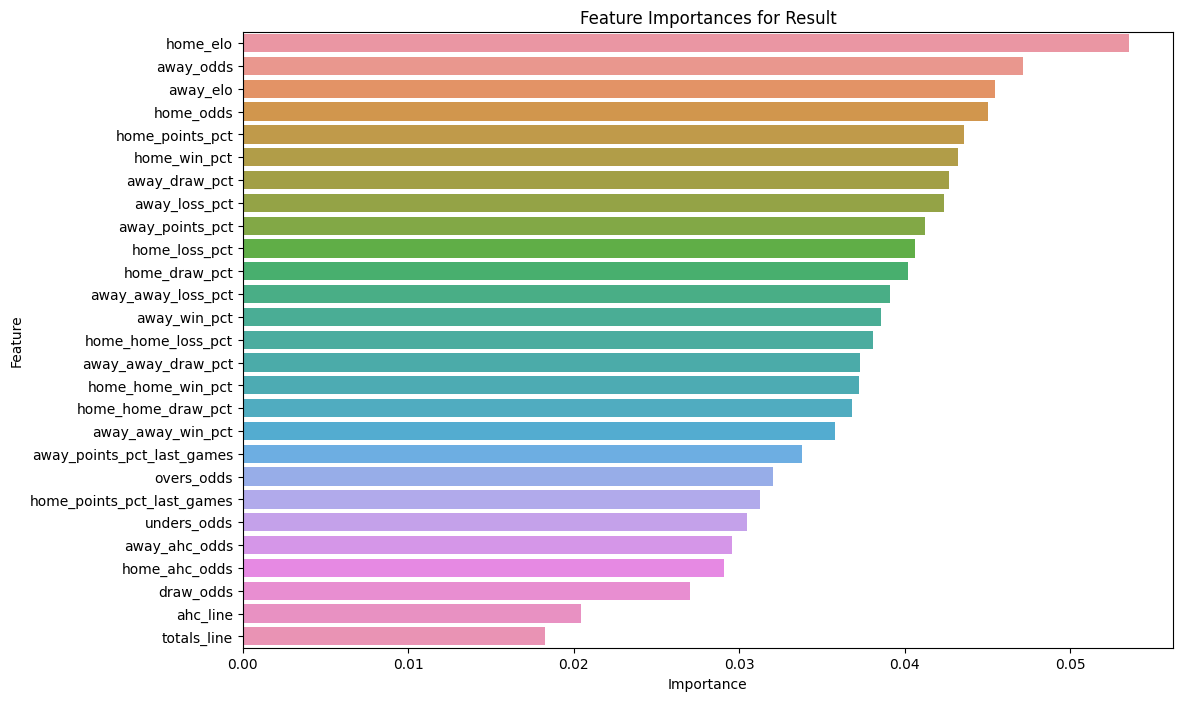

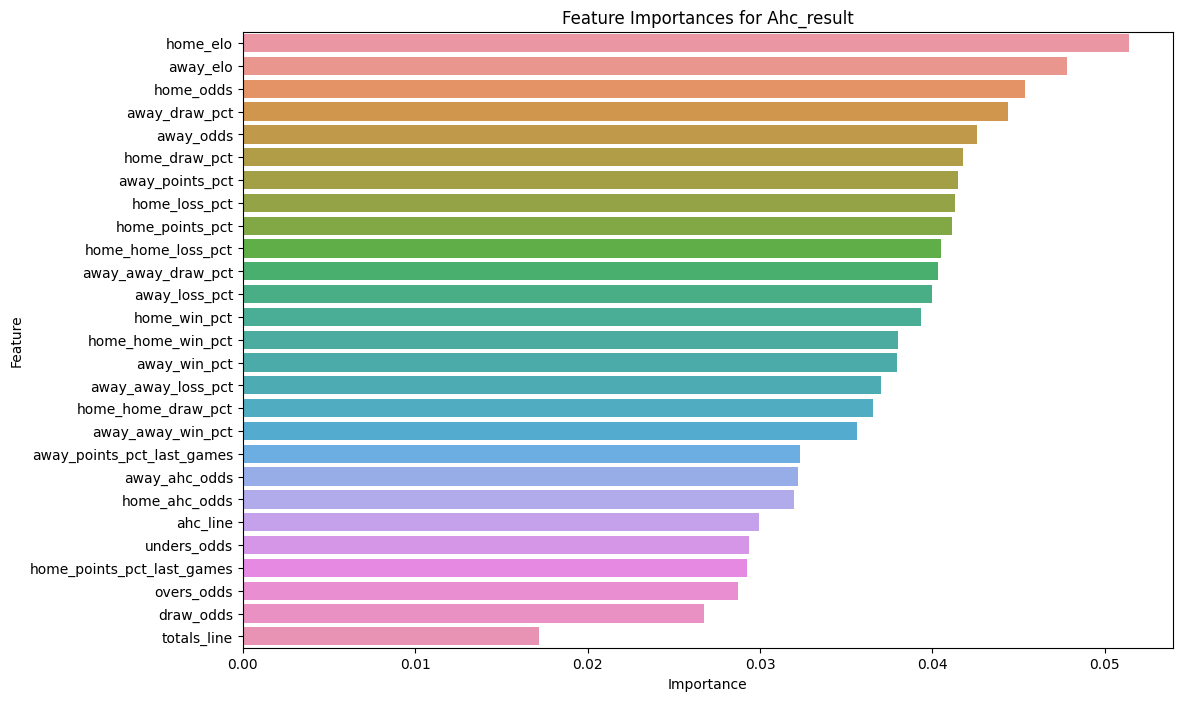

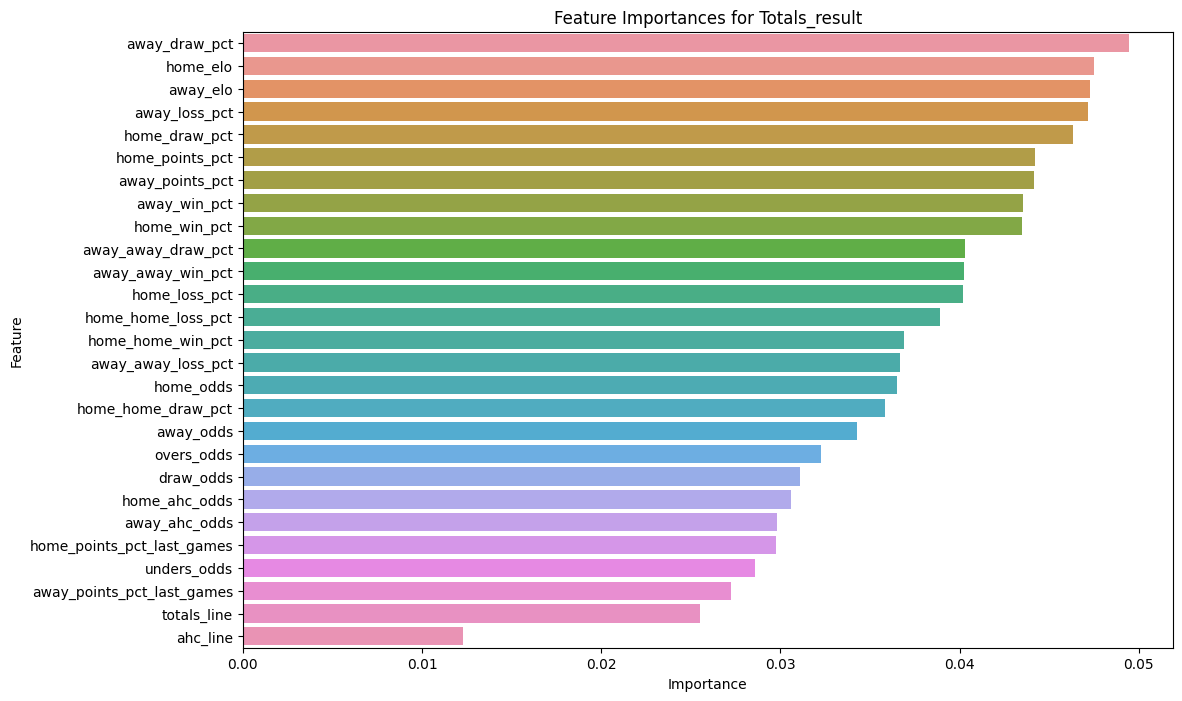

Feature Importances for Result:
Chart saved: feature_importance_result.png
Feature Importances for Ahc_result:
Chart saved: feature_importance_ahc_result.png
Feature Importances for Totals_result:
Chart saved: feature_importance_totals_result.png


In [9]:
# Replace feature importance cell with:

def show_feature_importances():
    return pf.display_random_forest_feature_importances(last_season_models, filtered_cols, logger=logger)

# Capture output and save ALL charts
logger.capture_print(show_feature_importances, "Random Forest Feature Importances")

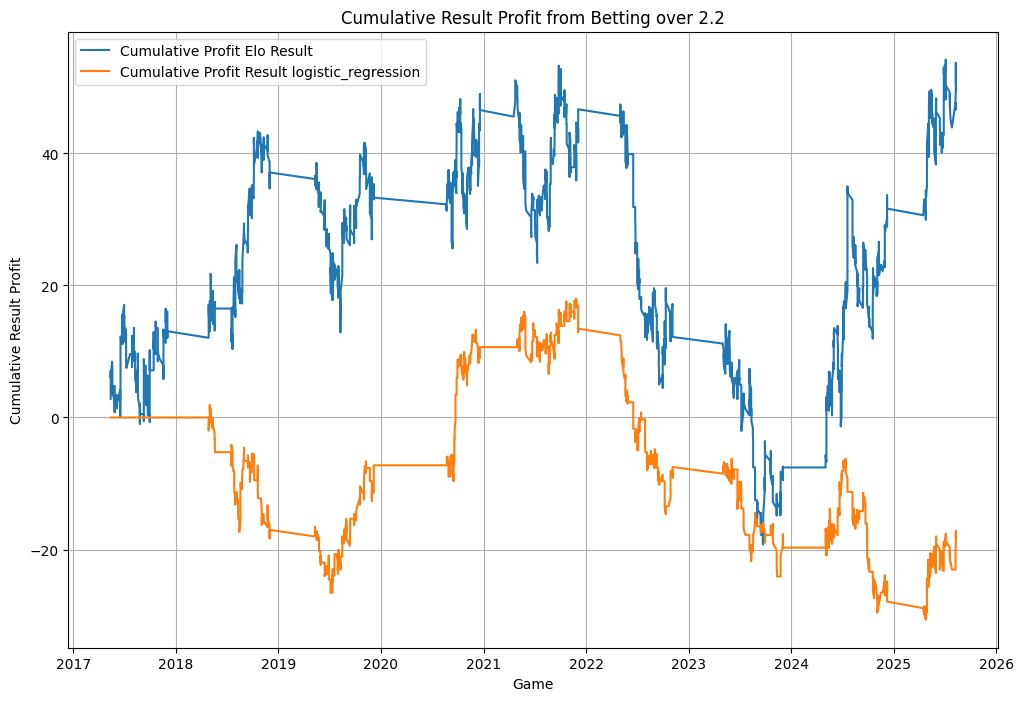

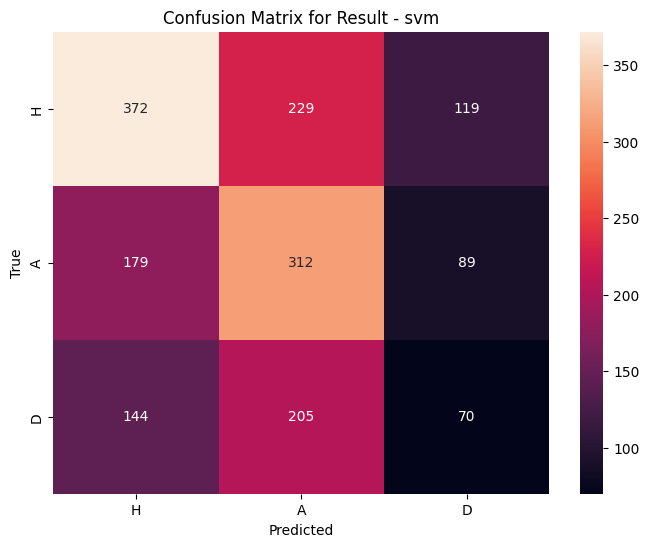

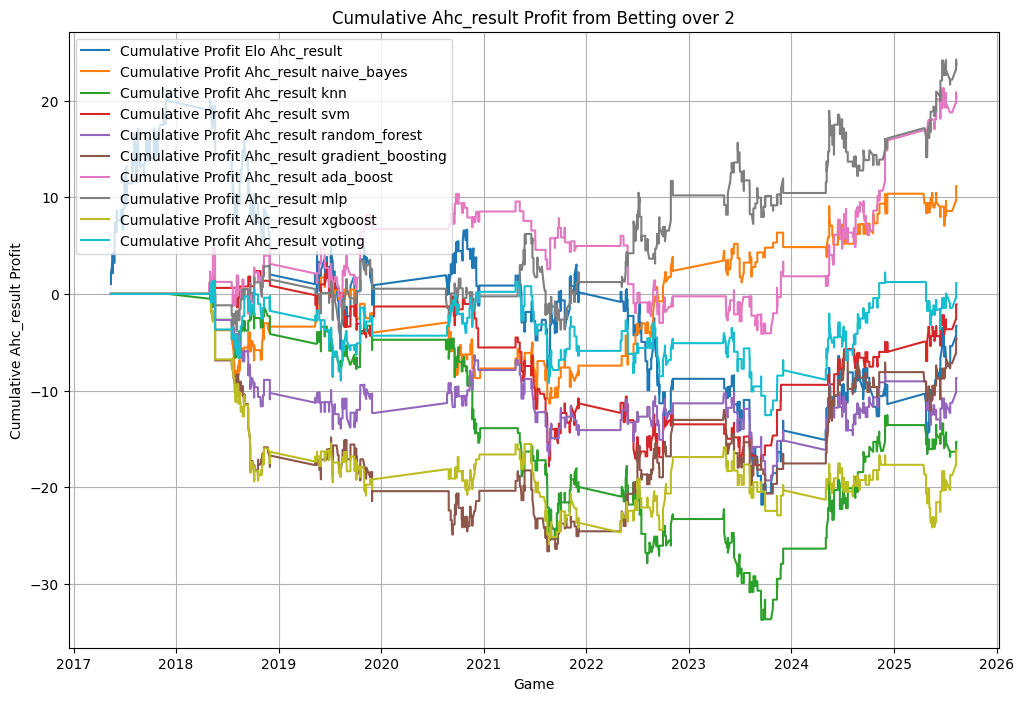

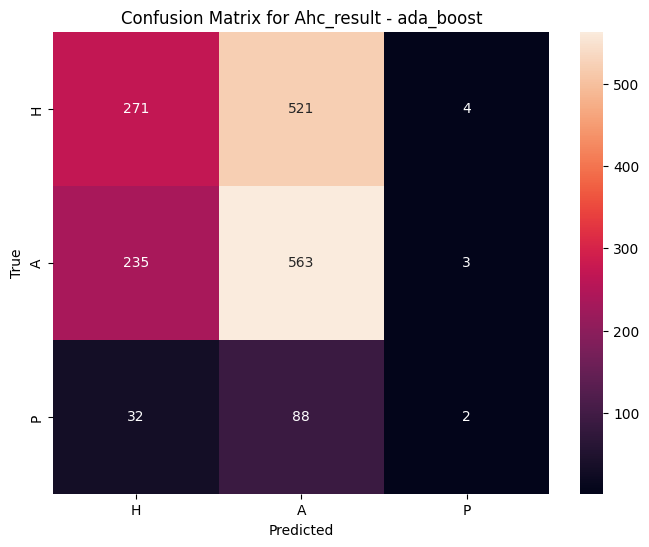

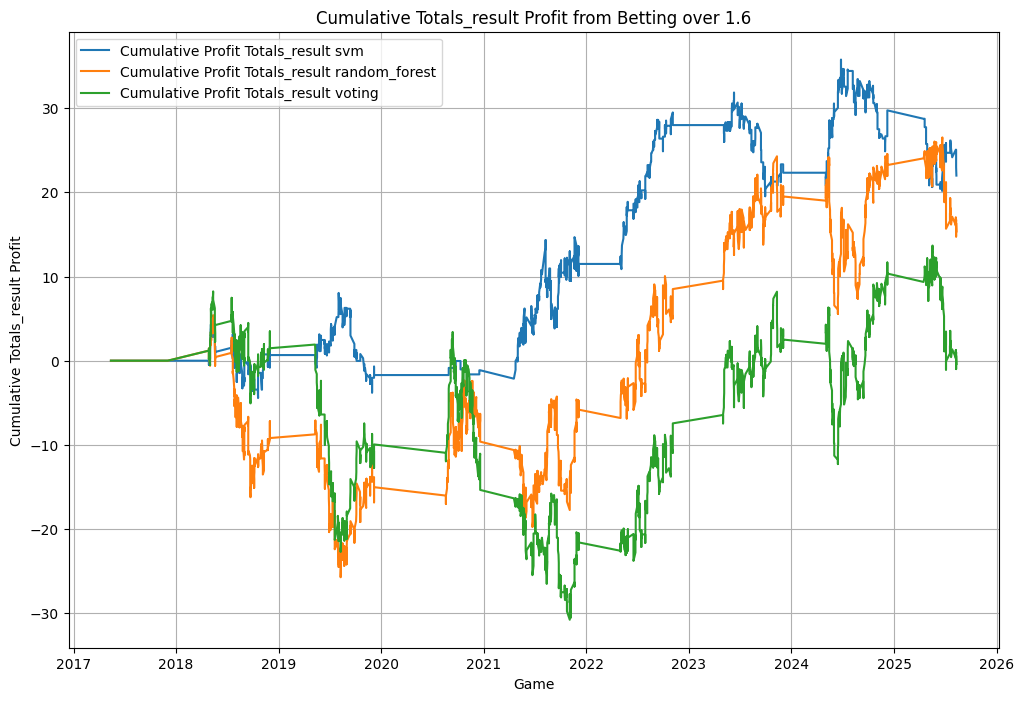

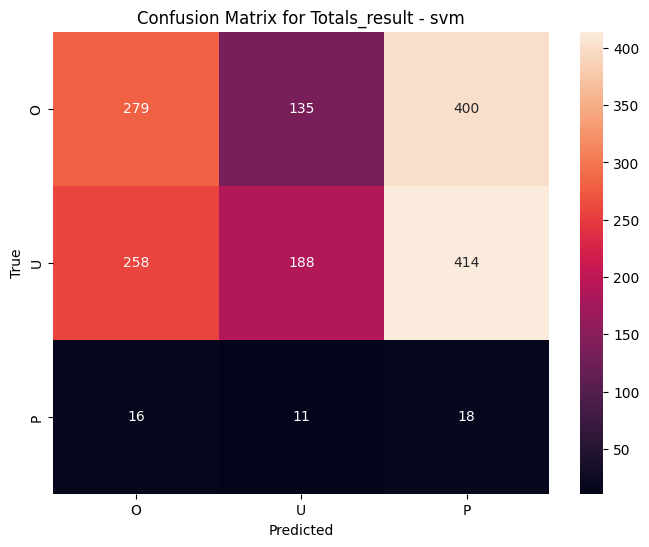

--------------------------------------------------
1x2 Classification Results
Chart saved: profit_analysis_result.png
Result Elo method (49.67/1576): 0.0315
Result Home method (-48.85/1095): -0.0446
Result method with naive_bayes          --> ( -33.87/851): -0.0398
Result method with knn                  --> ( -25.82/822): -0.0314
Result method with logistic_regression  --> ( -18.23/714): -0.0255
Result method with svm                  --> ( -22.39/880): -0.0254
Result method with random_forest        --> (-112.09/814): -0.1377
Result method with gradient_boosting    --> (-109.87/1007): -0.1091
Result method with ada_boost            --> ( -64.72/817): -0.0792
Result method with mlp                  --> ( -67.59/1277): -0.0529
Result method with xgboost              --> ( -85.89/1010): -0.085
Result method with voting               --> ( -57.25/736): -0.0778

Result Profit for svm: $-22.39

Result Yield for svm: $-0.0254
Result Accuracy for svm: 0.44
Result Classification Report for sv

In [ ]:
# Replace the profit analysis cell with:

min_odds_1x2 = markets["result"][1]
min_odds_ahc = markets["ahc_result"][1]
min_odds_totals = markets["totals_result"][1]

def run_profit_analysis():
    return pf.get_classification_simulation_results(
        matches,
        start_season,
        plot_threshold,
        bankroll,
        strategy,
        default_value,
        default_bankroll_pct,
        min_odds_1x2,
        min_odds_ahc,
        min_odds_totals,
        logger=logger,
        voting_models=voting_models
    )

# Capture profit analysis
best_models = logger.capture_print(run_profit_analysis, "Profit Analysis and Model Performance")
best_1x2_model, best_ahc_model, best_totals_model = best_models

In [15]:
# Save detailed model parameters
logger.save_model_parameters(last_season_models, markets)

# Capture the model parameters output as well
def show_model_params():
    for market_name, models in last_season_models.items():
        print(f"\n{'='*50}")
        print(f"MARKET: {market_name.upper()}")
        print(f"{'='*50}")
        
        for model_name, model_info in models.items():
            print(f"\nModel: {model_info['estimator'].__class__.__name__}")
            print(f"Model Key: {model_name}")
            print(f"Score: {model_info.get('score')}")
            print(f"Parameters: {model_info.get('params')}")
            
            if "pipeline" in model_info:
                pipeline_steps = list(model_info["pipeline"].named_steps.keys())
                print(f"Pipeline Steps: {pipeline_steps}")
                
                # Show model step parameters
                model_step = model_info["pipeline"].named_steps.get("model")
                if model_step:
                    print(f"Model Step Parameters: {model_step.get_params()}")
            print("-" * 40)

# Capture model parameters output
logger.capture_print(show_model_params, "Detailed Model Parameters for All Markets")

🔧 Model parameters saved: model_parameters.json

MARKET: RESULT

Model: GaussianNB
Model Key: naive_bayes
Score: None
Parameters: None
Pipeline Steps: ['model']
Model Step Parameters: {'priors': None, 'var_smoothing': 1e-09}
----------------------------------------

Model: KNeighborsClassifier
Model Key: knn
Score: None
Parameters: None
Pipeline Steps: ['model']
Model Step Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}
----------------------------------------

Model: LogisticRegression
Model Key: logistic_regression
Score: None
Parameters: None
Pipeline Steps: ['model']
Model Step Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-----------

In [16]:
# Create simulation summary
simulation_summary = {
    "simulation_info": {
        "league": league,
        "start_season": start_season,
        "end_season": matches['season'].max(),
        "total_matches": len(matches),
        "total_function_calls": len(function_calls),
        "execution_time": "N/A"  # You could add timing
    },
    "best_models": {
        "result": best_1x2_model,
        "ahc_result": best_ahc_model, 
        "totals_result": best_totals_model
    },
    "final_bankroll": {
        "result": matches[f'CumulativeProfitML_{best_1x2_model}'].iloc[-1] if f'CumulativeProfitML_{best_1x2_model}' in matches.columns else None,
        "ahc_result": matches[f'CumulativeProfitML_{best_ahc_model}'].iloc[-1] if f'CumulativeProfitML_{best_ahc_model}' in matches.columns else None,
        "totals_result": matches[f'CumulativeProfitML_{best_totals_model}'].iloc[-1] if f'CumulativeProfitML_{best_totals_model}' in matches.columns else None,
    },
    "model_performance": {
        model_name: {
            "accuracy": models[model_name].get("score"),
            "params": models[model_name].get("params")
        } for model_name in models.keys()
    },
    "last_season_models_summary": {
        market: {
            model_name: {
                "estimator": model_info["estimator"].__class__.__name__,
                "score": model_info.get("score"),
                "params": model_info.get("params")
            }
            for model_name, model_info in market_models.items()
        }
        for market, market_models in last_season_models.items()
    }
}

execution_time = time.time() - start_time
simulation_summary["simulation_info"]["execution_time"] = f"{execution_time:.2f} seconds"

# Finalize logging
logger.finalize(simulation_summary)

print(f"\n🎉 Simulation complete! All results saved to:")
print(f"📁 {logger.simulation_dir}")

✅ Simulation logged to: ../dist/simulations\japan-j1-league\2025-08-30_12-10-05

🎉 Simulation complete! All results saved to:
📁 ../dist/simulations\japan-j1-league\2025-08-30_12-10-05


In [17]:
def save_pipeline(market_str, last_season_models, best_model_name):
    pipeline = last_season_models[market_str][best_model_name].get("pipeline")
    
    data = {
        "pipeline": pipeline,
        "best_model_name": best_model_name,
        "min_games_played": min_games_played,
        "min_games_played_at": min_games_played_at,
        "markets": markets,
        "filtered_cols": filtered_cols,
        "strategy": strategy,
        "default_value": default_value,
        "default_bankroll_pct": default_bankroll_pct
    }

    path = f"../dist/betting/{league}"
    save_file(path, data, market_str)

    print(f"Pipeline for market {market_str} and model {best_model_name} saved.")

# Save the pipeline
if save_pipeline_bool:
    save_pipeline("result", last_season_models, best_1x2_model)
    save_pipeline("ahc_result", last_season_models, best_ahc_model)
    save_pipeline("totals_result", last_season_models, best_totals_model)

Pipeline for market result and model svm saved.
Pipeline for market ahc_result and model ada_boost saved.
Pipeline for market totals_result and model svm saved.
